#Исследовательский анализ данных (EDA)

##**Цель блокнота:**
* понять данные
* проверить качество
* получить первые продуктовые метрики

##**1. Загрузка данных**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
customers = pd.read_csv(
    "olist_customers_dataset.csv")

# Изменим сразу тип данных
orders = pd.read_csv(
    "olist_orders_dataset.csv",
    parse_dates=[
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date"
    ],
    dtype={
        "order_id": "string",
        "customer_id": "string",
        "order_status": "string"
    }
)

payments = pd.read_csv(
    "olist_order_payments_dataset.csv")

items = pd.read_csv(
    "olist_order_items_dataset.csv",
    parse_dates=["shipping_limit_date"]
)


##**2. Первичный осмотр**

In [ ]:
customers.head()
orders.head()
payments.head()
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [ ]:
print('Размеры таблиц\n')
print("customers:", customers.shape)
print("orders:", orders.shape)
print("payments:", payments.shape)
print("items:", items.shape)


Размеры таблиц

customers: (99441, 5)
orders: (99441, 8)
payments: (103886, 5)
items: (112650, 7)


In [ ]:
print('Пропуски в данных')
orders.isna().mean().sort_values(ascending=False)

Пропуски в данных


,0
order_delivered_customer_date,0.029817
order_delivered_carrier_date,0.017930
order_approved_at,0.001609
order_id,0.000000
order_purchase_timestamp,0.000000
order_status,0.000000
customer_id,0.000000
order_estimated_delivery_date,0.000000


In [ ]:
print('Дубликаты заказов')
orders["order_id"].duplicated().sum()

Дубликаты заказов


np.int64(0)

In [ ]:
# Статусы заказов
orders["order_status"].value_counts(normalize=True)

,proportion
order_status,
delivered,0.970203
shipped,0.011132
canceled,0.006285
unavailable,0.006124
invoiced,0.003158
processing,0.003027
created,0.00005
approved,0.00002


Не все заказы успешны, поэтому для продуктов метрик дальше будем учитывать только доставленные (`delivered`)


##**3. Подготовка данных**

In [ ]:
customers_unique = customers[["customer_id", "customer_unique_id"]]

In [ ]:
# объединяем пользователей и заказы
orders_users = orders.merge(
    customers_unique,
    on="customer_id",
    how="left")

In [ ]:
# Проверка
orders_users.isna().sum()

,0
order_id,0
customer_id,0
order_status,0
order_purchase_timestamp,0
order_approved_at,160
order_delivered_carrier_date,1783
order_delivered_customer_date,2965
order_estimated_delivery_date,0
customer_unique_id,0


##**4. Базовые продуктовые метрики**

### **4.1 Активные пользователи**

In [ ]:
# Пользователи хотя с одной транзакцией
total_users = orders_users["customer_unique_id"].nunique()
print("Всего активных пользователей:", total_users)

total_orders = orders_users["order_id"].nunique()
print("Всего заказов:", total_orders)

orders_per_user = total_orders / total_users
print("Среднее количество заказов на пользователя:", round(orders_per_user, 2))

Всего активных пользователей: 96096
Всего заказов: 99441
Среднее количество заказов на пользователя: 1.03


In [ ]:
# Пользователи с успешной транзакцией
delivered_orders = orders_users[
    orders_users["order_status"] == "delivered"]

delivered_users = delivered_orders["customer_unique_id"].nunique()
print('Пользователей с успешными транзакциями:', delivered_users)

Пользователей с успешными транзакциями: 93358


### **4.2 Поведение пользователей**

In [ ]:
orders_by_user = (
    delivered_orders.groupby("customer_unique_id")["order_id"].nunique().reset_index(name="orders_cnt"))

print ('Распределение заказов на пользователя')
orders_by_user["orders_cnt"].value_counts().head()


Распределение заказов на пользователя


,count
orders_cnt,
1,90557
2,2573
3,181
4,28
5,9


In [ ]:
repeat_users_share = (
    orders_by_user[orders_by_user["orders_cnt"] > 1].shape[0]
    / orders_by_user.shape[0])

print('Доля пользователей с повторными заказами')
round(repeat_users_share, 2)

Доля пользователей с повторными заказами


0.03

Большинство пользователей делают лишь одну транзакцию

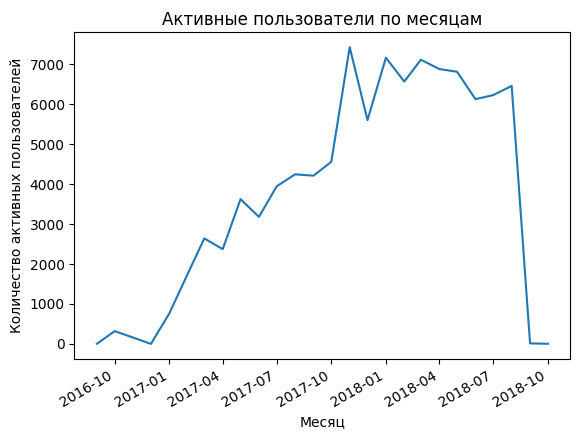

In [ ]:
# Активность пользователей во времени
orders_users["order_month"] = (
    orders_users["order_purchase_timestamp"].dt.to_period("M").dt.to_timestamp()
)

monthly_active_users = (
    orders_users.groupby("order_month")["customer_unique_id"].nunique()
)

plt.figure()
monthly_active_users.plot()
plt.title("Активные пользователи по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Количество активных пользователей")
plt.show()


Динамика активных пользователей по месяцам задаёт контекст
для дальнейшего когортного анализа и оценки удержания.


### **4.3 Платежное поведение**

In [ ]:
print('Способы оплаты: ')
payments["payment_type"].value_counts(normalize=True)

Способы оплаты: 


,proportion
payment_type,
credit_card,0.739224
boleto,0.190440
voucher,0.055590
debit_card,0.014718
not_defined,0.000029


In [ ]:
order_revenue = (
    payments.groupby("order_id")["payment_value"].sum().reset_index(name="order_revenue")
)
print('Информация о чеке')
order_revenue["order_revenue"].describe()


Информация о чеке


,order_revenue
count,99440.000000
mean,160.990267
std,221.951257
min,0.000000
25%,62.010000
50%,105.290000
75%,176.970000
max,13664.080000


##**5. Первые продуктовые выводы**

1. Не все заказы создают ценность, поэтому дальнейший анализ будет учитывать только успешные (`delivered`) заказы

2. Большинство пользователей совершают только одну транзакцию, крайне низкое удержание (~97% пользователей совершают только одну транзакцию).

3. Наиболее узкое место в пользовательской воронке - это переход от первой транзакции ко второй. Даже небольшое улучшение конверсии на этом этапе может существенно повлиять на количество транзакций

4. ~74% оплачивают банковской картой, возможно, есть смысл оптимизировать этот способ оплаты
